In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#U-Net Original Research Paper
Paper Name: U-Net: Convolutional Networks for Biomedical Image Segmentation<br>
Paper Link: https://arxiv.org/pdf/1505.04597.pdf

#Configs

In [3]:
class ROOTDIR:
    train = "/content/drive/MyDrive/testing_imag_data/archive/data/data/images"
    train_mask = "/content/drive/MyDrive/testing_imag_data/archive/data/data/masks"

#General Imports

In [4]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

#Working with Train Images and Masks

In [5]:
from PIL import Image

In [8]:
#os.mkdir("masks")
for imgname in os.listdir(ROOTDIR.train_mask):
    img = Image.open('/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/'+imgname) # open colour image
    img = img.convert('L') # convert image to black and white
    img.save('/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/'+imgname)
    '''img=cv2.imread('..\\input\\leaf-disease-segmentation-dataset\\data\\data\\masks'+imgname)
    print(type(img))
    img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img=cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    cv2.imwrite(imgname, img)'''

In [9]:
ROOTDIR.train_mask="/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/"

In [10]:
train_img_lst = os.listdir(ROOTDIR.train) # "./train"
train_mask_lst = os.listdir(ROOTDIR.train_mask) # "./train_masks"

In [11]:
print(train_mask_lst[:5])
print(train_img_lst[:5])

['00312.png', '00464.png', '00360.png', '00300.png', '00350.png']
['00017.jpg', '00124.jpg', '00062.jpg', '00091.jpg', '00016.jpg']


In [12]:
print(len(train_mask_lst))
print(len(train_img_lst))

588
588


###Sorting to make sure we get right image and right mask

In [13]:
sorted_train_mask_lst = sorted(train_mask_lst)

In [14]:
sorted_train_img_lst = sorted(train_img_lst)

In [15]:
print(sorted_train_mask_lst[:16])
print(sorted_train_img_lst[:16])

['00000.png', '00001.png', '00002.png', '00003.png', '00004.png', '00005.png', '00006.png', '00007.png', '00008.png', '00009.png', '00010.png', '00011.png', '00012.png', '00013.png', '00014.png', '00015.png']
['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg']


#Visualizing Images with their Mask
Making sure images and mask are paired correctly.

/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00000.jpg
(326, 235)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


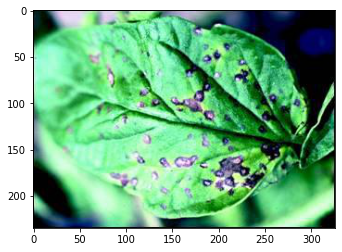

/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00000.png
(326, 235)


----------------------------------------------------
/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00001.jpg
(326, 234)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00001.png
(326, 234)


----------------------------------------------------


In [16]:
def show_images(imgs_lst,masks_lst,loops=2):
    for i in range(loops):
        img_path = os.path.join(ROOTDIR.train,imgs_lst[i])
        mask_path = os.path.join(ROOTDIR.train_mask,masks_lst[i])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

show_images(sorted_train_img_lst, sorted_train_mask_lst)

#PyTorch Imports

In [17]:
import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset

#PyTorch Configuration

In [18]:
class CFG:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    split_pct = 0.2
    learning_rate = 3e-4
    batch_size = 4
    epochs = 30

In [19]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

In [20]:
CFG.device

device(type='cpu')

#Working with data
Shuffling the data.

In [21]:
#permuted_train_img_lst = np.random.permutation(np.array(sorted_train_img_lst))
#permuted_train_mask_lst = [x.replace(".jpg", "_mask.gif") for x in permuted_train_img_lst]
print(sorted_train_img_lst[:5])
print(sorted_train_mask_lst[:5])

['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg']
['00000.png', '00001.png', '00002.png', '00003.png', '00004.png']


/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00000.jpg
(326, 235)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


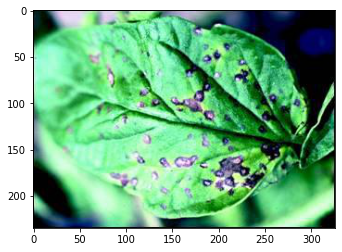

/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00000.png
(326, 235)


----------------------------------------------------
/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00001.jpg
(326, 234)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00001.png
(326, 234)


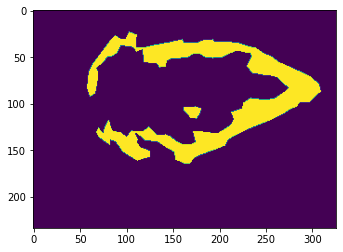

----------------------------------------------------


In [22]:
show_images(sorted_train_img_lst,sorted_train_mask_lst)

###Splitting into Training and Validation

In [23]:
length = len(sorted_train_img_lst)
print(length*0.2) # convert this to int

117.60000000000001


In [24]:
train_images_list = sorted_train_img_lst[int(CFG.split_pct*len(sorted_train_img_lst)) :]
train_masks_list = sorted_train_mask_lst[int(CFG.split_pct*len(sorted_train_mask_lst)) :]
print(len(train_masks_list))

val_images_list = sorted_train_img_lst[: int(CFG.split_pct*len(sorted_train_img_lst))]
val_masks_list = sorted_train_mask_lst[: int(CFG.split_pct*len(sorted_train_mask_lst))]
print(len(val_masks_list))

# 4071+1017=5088 (split includes all items)

471
117


###Visualizing Train Dataset

/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00117.jpg
(257, 348)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00117.png
(257, 348)


----------------------------------------------------
/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00118.jpg
(269, 271)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00118.png
(269, 271)


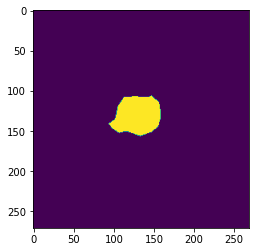

----------------------------------------------------


In [25]:
show_images(train_images_list,train_masks_list)

###Visualizing Validation Dataset

/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00000.jpg
(326, 235)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


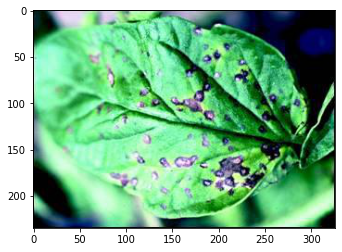

/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00000.png
(326, 235)


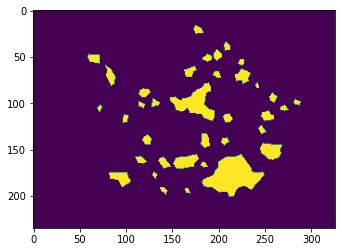

----------------------------------------------------
/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00001.jpg
(326, 234)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


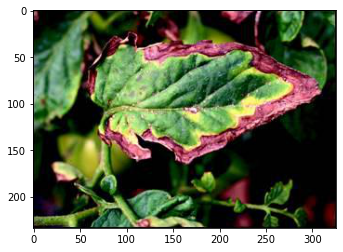

/content/drive/MyDrive/testing_imag_data/archive/data/data/masks/00001.png
(326, 234)


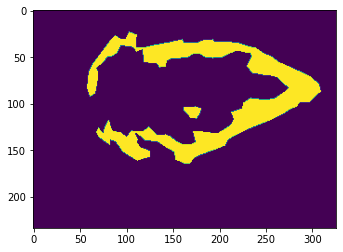

----------------------------------------------------


In [26]:
show_images(val_images_list,val_masks_list)

#Dataset Class

In [27]:
class CarvanaDataset(Dataset):
    def __init__(self,img_list,mask_list,transform=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,index):
        img_path = os.path.join(ROOTDIR.train,self.img_list[index])
        mask_path = os.path.join(ROOTDIR.train_mask,self.mask_list[index])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0
        #img_mask_dict = {"image": img, "mask": mask}
        
        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)
            #transformations = self.transform(image=img, mask=mask)
            #img = transformations["image"]
            #mask = transformations["mask"]
            
        return img,mask

In [28]:
train_transform = A.Compose([A.Resize(572,572), 
                             A.Rotate(limit=15,p=0.1),
                             A.HorizontalFlip(p=0.5),
                             A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(572,572),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [29]:
train_dataset = CarvanaDataset(train_images_list, train_masks_list, transform = train_transform)
val_dataset = CarvanaDataset(val_images_list, val_masks_list, transform = train_transform)

In [30]:
idx = 200
img,mask = train_dataset[idx]

In [31]:
mask.shape

torch.Size([1, 572, 572])

In [32]:
img.max()

tensor(1.)

In [43]:
"""def show_single_img(img,mask,index=None,train=True):
    if index:
        if train:
            img,mask = train_dataset[index]
        else:
            img,mask = val_dataset[index]
    plt.imshow(img.permute(1,2,0),cmap="gray")  # Convert (3, 572, 572) -> (572, 572, 3)
    plt.show()
    plt.imshow(mask.permute(1,2,0), cmap="gray")  # Convert (1, 572, 572) -> (572, 572, 1)
    print(mask.shape)
    plt.show()"""

In [ ]:
"""print("---------------Train---------------")
show_single_img(img[:,:,0],mask,index=15,train=False)
print("---------------Validation---------------")
show_single_img(img[:,:,0],mask,index=15,train=True)"""

#Dataloader

In [45]:
train_dataloader = DataLoader(train_dataset,batch_size=CFG.batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=CFG.batch_size,shuffle=False)

In [48]:
a = iter(train_dataloader)
#img,mask = a.next()
img,mask = next(a)
print(img.shape,mask.shape)

torch.Size([4, 3, 572, 572]) torch.Size([4, 1, 572, 572])


###Utility Functions

In [49]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv

#def cropper(og_tensor, target_tensor):
#    og_shape = og_tensor.shape[2]
#    target_shape = target_tensor.shape[2]
#    delta = (og_shape - target_shape) // 2
#    cropped_og_tensor = og_tensor[:,:,delta:og_shape-delta,delta:og_shape-delta]
#    return cropped_og_tensor
 
    
def padder(left_tensor, right_tensor): 
    # left_tensor is the tensor on the encoder side of UNET
    # right_tensor is the tensor on the decoder side  of the UNET
    
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(CFG.device)
    
    return right_tensor.to(CFG.device)

#UNET MODEL FROM SCRATCH

In [50]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        #print(self.down_conv_1)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)
        
    def forward(self,x):
        
        # encoding
        x1 = self.down_conv_1(x)
        #print("X1", x1.shape)
        p1 = self.max_pool(x1)
        #print("p1", p1.shape)
        x2 = self.down_conv_2(p1)
        #print("X2", x2.shape)
        p2 = self.max_pool(x2)
        #print("p2", p2.shape)
        x3 = self.down_conv_3(p2)
        #print("X2", x3.shape)
        p3 = self.max_pool(x3)
        #print("p3", p3.shape)
        x4 = self.down_conv_4(p3)
        #print("X4", x4.shape)
        p4 = self.max_pool(x4)
        #print("p4", p4.shape)
        x5 = self.down_conv_5(p4)
        #print("X5", x5.shape)
        
        # decoding
        d1 = self.up_conv_trans_1(x5)  # up transpose convolution ("up sampling" as called in UNET paper)
        pad1 = padder(x4,d1) # padding d1 to match x4 shape
        cat1 = torch.cat([x4,pad1],dim=1) # concatenating padded d1 and x4 on channel dimension(dim 1) [batch(dim 0),channel(dim 1),height(dim 2),width(dim 3)]
        uc1 = self.up_conv_1(cat1) # 1st up double convolution
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1
        #print(conv_1x1.shape)

#Training and Validation
Train Function

In [51]:
def train_model(model,dataloader,criterion,optimizer):
    model.train()
    train_running_loss = 0.0
    for j,img_mask in enumerate(tqdm(dataloader)):
        img = img_mask[0].float().to(CFG.device)
        #print(" ----- IMAGE -----")
        #print(img)
        mask = img_mask[1].float().to(CFG.device)
        #print(" ----- MASK -----")
        #print(mask)
        
        y_pred = model(img)
        #print(" ----- Y PRED -----")
        #print(y_pred)
        #print(" ----- Y PRED SHAPE -----")#
        #print(y_pred.shape)
        optimizer.zero_grad()
        
        loss = criterion(y_pred,mask)
        
        train_running_loss += loss.item() * CFG.batch_size
        
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / (j+1)
    return train_loss

###Validation Function

In [52]:
def val_model(model,dataloader,criterion,optimizer):
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for j,img_mask in enumerate(tqdm(dataloader)):
            img = img_mask[0].float().to(CFG.device)
            mask = img_mask[1].float().to(CFG.device)
            y_pred = model(img)
            loss = criterion(y_pred,mask)
            
            val_running_loss += loss.item() * CFG.batch_size
            
        val_loss = val_running_loss / (j+1)
    return val_loss

In [53]:
model = UNET(in_chnls = 3, n_classes = 1).to(CFG.device)
optimizer = optim.Adam(model.parameters(), lr = CFG.learning_rate)
criterion = nn.BCEWithLogitsLoss()
train_loss_lst = []
val_loss_lst = [] 

###Train and Validation Loop

In [ ]:
for i in tqdm(range(CFG.epochs)):
    train_loss = train_model(model=model,dataloader=train_dataloader,criterion=criterion,optimizer=optimizer)
    val_loss = val_model(model=model,dataloader=val_dataloader,criterion=criterion,optimizer=optimizer)
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)
    print(f" Train Loss : {train_loss:.4f}")
    print(f" Validation Loss : {val_loss:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -62.7784
 Validation Loss : -137.3031


  0%|          | 0/118 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

###Training and Validation Loss Plot

In [ ]:
plt.plot(train_loss_lst, color="green", label='train loss')
plt.plot(val_loss_lst, color="red", label='validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#Saving Model

In [ ]:
TRAINED_FILE = "unet_scratch.pth"

In [ ]:
torch.save(model.state_dict(), TRAINED_FILE)

In [ ]:
from IPython.display import FileLink
FileLink(TRAINED_FILE)

#Testing

In [ ]:
trained_model = UNET(in_chnls = 3, n_classes = 1)

In [ ]:
#UNET_TRAINED = "../input/unet-4-epoch-trained/unet_scratch.pth"
UNET_TRAINED = "unet_scratch.pth"

In [ ]:
trained_model.load_state_dict(torch.load(UNET_TRAINED))

In [ ]:
trained_model = trained_model.to("cuda")
trained_model.eval()

In [ ]:
#img_path = "../input/carvana-image-masking-challenge/29bb3ece3180_11.jpg"
img_path = "/content/drive/MyDrive/testing_imag_data/archive/data/data/images/00028.jpg"
img = cv2.imread(img_path)

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
test_transform = A.Compose([A.Resize(572,572),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [ ]:
test_image = test_transform(image = img)

print(test_image)

print(test_image["image"].dtype)
print(test_image["image"].shape)

img = test_image["image"].unsqueeze(0)
print(img.shape)

img = img.to("cuda")

In [ ]:
pred = trained_model(img)
pred.shape

In [ ]:
mask = pred.squeeze(0).cpu().detach().numpy()
print(mask.shape)
mask = mask.transpose(1,2,0)
print(mask.shape)

In [ ]:
display_test_img = test_image["image"].cpu().detach().numpy()
print(display_test_img.shape)
display_test_img = display_test_img.transpose(1,2,0)
display_test_img.shape

In [ ]:
mask[mask < 0]=0
mask[mask > 0]=1

In [ ]:
print("-------Original Image-------")
plt.imshow(display_test_img, cmap="gray")
plt.show()
print("-------Image Mask-------")
plt.imshow(mask,cmap="gray")
plt.show()

#webapp using streamlit

In [ ]:
!pip install streamlit
!pip install pyngrok===4.1.1
from pyngrok import ngrok

In [ ]:
%%writefile frontend.py

import streamlit as st


def detect(img_path):
    img = cv2.imread(img_path)
    test_transform = A.Compose([A.Resize(572,572), A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255), ToTensorV2()])
    test_image = test_transform(image = img)
    img = test_image["image"].unsqueeze(0)
    img = img.to("cuda")
    pred = trained_model(img)
    mask = pred.squeeze(0).cpu().detach().numpy()
    mask = mask.transpose(1,2,0)
    mask[mask < 0]=0
    mask[mask > 0]=1
    cv2.imwrite(mask, "result.jpg")
    return True

trained_model = UNET(in_chnls = 3, n_classes = 1)
UNET_TRAINED = "unet_scratch.pth"
trained_model.load_state_dict(torch.load(UNET_TRAINED))
#model = pkl.load(open("unet_scratch.pth", "rb"))

st.title("LEAF DISEASE DETECTION")
st.subheader("Leaf disease detection is used to detect the area of leaf in the image that is being infected")

st.markdown("**************")
st.title("Identify Disease")
imagefile = st.file_uploader("select an image containing any type of leaf", type=(["jpg", "png", "jpeg"]))
if imagefile is not None:
    from pathlib import Path
    path = Path(imagefile.name)
else:
    path = None
if st.button("Start Detection"):
    success = detect(path)
    if success:
        st.success("Image saved with detected disease")
    #st.image(imagefile, use_column_width=True, clamp=True)

In [ ]:
!nohup streamlit run frontend.py &
url = ngrok.connect(port='8501')
url